# Household Structured Epidemic Model

Here we use a transmission rule that allows transmission to differ based on whether people have some shared trait to create an epidemic model with household structure. Here folks are far more likely to transmit to others in their household, and move through the standard S, I and R states once infected. 

First imports and setup.

In [1]:
import sys
sys.path.append('../')
import tabularepimdl as tepi

import pandas as pd
import numpy as np

import plotly.express as px

## Defining a Population

The population is going to consist of 500 households with a mean size of 2. We will add an infected person to the last household on the list (HH number 499). 

In [2]:
##create a population with 500 households of average size 2 and one
##person infected in the 500th household
np.random.seed(3) #make sure every time the random function generates the same numbers
hh_pop = pd.DataFrame({
    'InfState':pd.Categorical(["S"]*500+["I"],  categories=['S','I','R']),
    'HH_Number': list(range(500))+[499],
    'N': list(np.random.poisson(2,500))+[1],
    'T':0
})

hh_pop.tail()

,InfState,HH_Number,N,T
496,S,496,1,0
497,S,497,2,0
498,S,498,4,0
499,S,499,1,0
500,I,499,1,0


In [3]:
#Note: if there are duplicate records in HH_Number and T, then dataframe should group them first before the data is processed.
#hh_pop = hh_pop.groupby(['HH_Number', 'InfState', 'T'], observed=True)['N'].sum().reset_index()
#hh_pop

## Creating an Epidemic Model

To define the epidemic model we will use a transmission rule that allows us to specify different transmission probabilities for those inside and outside of the household. Here we will assume that those inside the household have a 20% chance of transmitting to a fellow household member, and that they have a 0.2% chance transmitting to someone outside. Given an average household size of 0.2 and a total population of approximately 1000, $R_0$ is approximately:
$$R_0 \approx (0.2)*(2) + (0.02)(1000) = 2.4$$

We will further presume infection lasts an average of 5 days.

In [4]:
num_of_days = 5
hh_mdl = tepi.EpiModel(hh_pop,
                 [tepi.SharedTraitInfection(0.2/num_of_days, 0.002/num_of_days,"InfState","HH_Number"),
                  tepi.SimpleTransition("InfState","I","R", 0.2)])

## Comparison with an unstructured SIR model

How does houehold structure change the shape of the epidemic curve, even if transmission is determinstic? We will need a standard SIR model with an equivalent R0 to compare to.

In [5]:
#First let's get the an equivalent population that does not have the population structure.
simp_pop = hh_pop.copy().drop("HH_Number", axis=1)
simp_pop = simp_pop.groupby(["InfState","T"], observed=False).sum().reset_index()


# Now create the standard SIR epidemic model
sir_mdl = tepi.EpiModel(init_state=simp_pop, rules= [
    tepi.SimpleInfection(beta=2.4/num_of_days, column='InfState'),
    tepi.SimpleTransition(column='InfState', from_st='I', to_st='R', rate=0.2)
])


C:\Users\lyue\AppData\Local\Temp\ipykernel_6736\1082116016.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  simp_pop = simp_pop.groupby(["InfState","T"]).sum().reset_index()


Now that we have both of these models let's run both deterministically and compare results.

In [6]:
for i in range(400):
    hh_mdl.do_timestep(dt=0.25)
    sir_mdl.do_timestep(dt=0.25)




In [7]:
#get the number infected at each time step from the hh_mdl
hh_res = hh_mdl.full_epi.copy().drop("HH_Number", axis=1)
hh_res = hh_res.groupby(["InfState","T"]).sum().reset_index()
hh_res["mdl"] = "HH"

sir_res = sir_mdl.full_epi.copy()
sir_res["mdl"] = "SIR"

all_res = pd.concat([hh_res, sir_res])

epi_fig_determ = px.line(all_res, x="T", y="N", color="InfState",line_dash="mdl", title="Household_structured deterministic Epi model vs. simple SIR model")
epi_fig_determ.show()

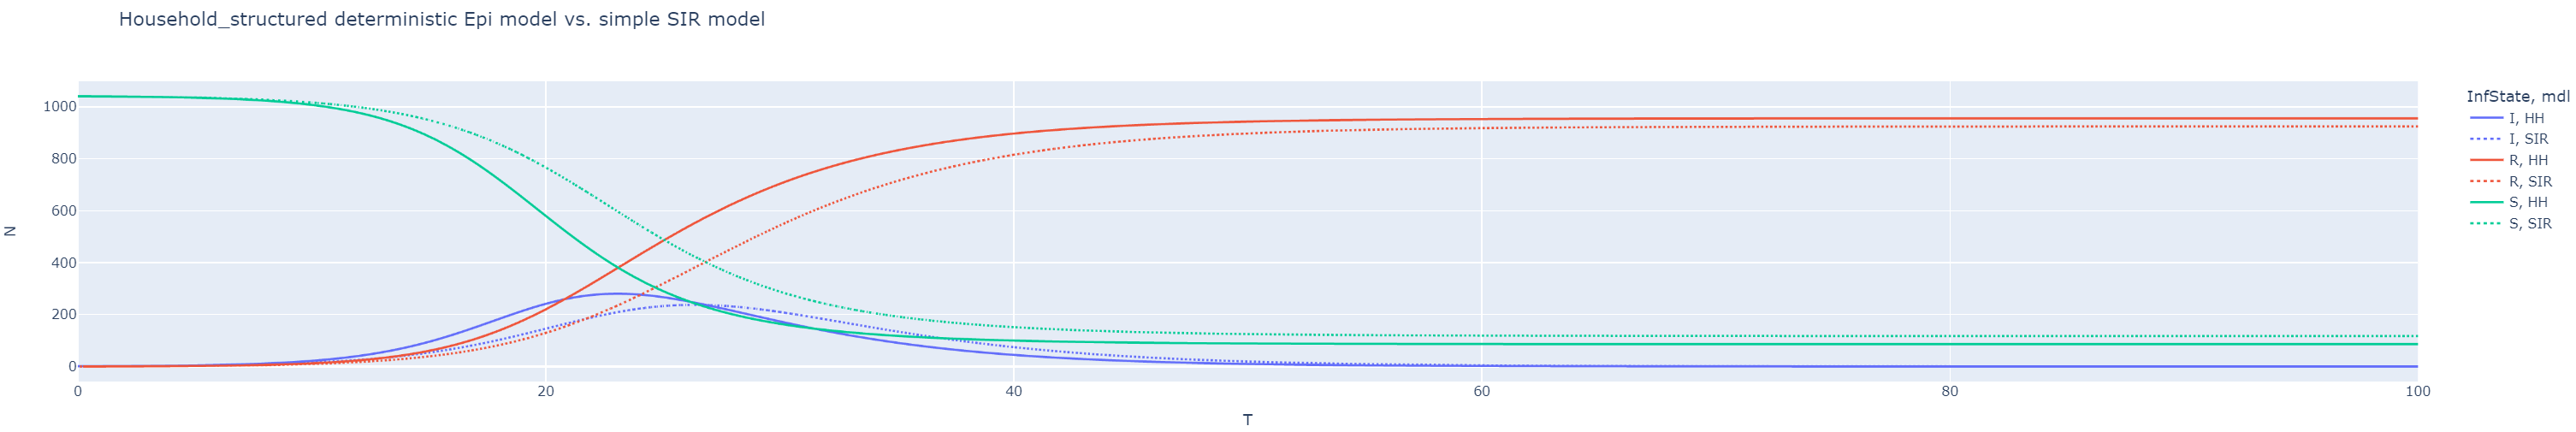

## Comparing Stochastic and Deterministic Results

The household process is actually a bit more intesting from the stochastic prospective. Let's now compare that with the deterministic results, particularly around differences in household attack rates.


In [8]:
## Reset the model and set it to be stochastic
hh_mdl.reset()
hh_mdl.stoch_policy="stochastic"

##just to guarantee we get something
np.random.seed(3)

##Now run an epidemic
for i in range(400):
    hh_mdl.do_timestep(dt=0.25)


Now let's look at some results of this run, including the epidemic curve compared to the non-stochastic version 
and the distribution of attack rate.

In [9]:
hh_res_stoch = hh_mdl.full_epi.copy()
hh_res_stoch = hh_res_stoch.groupby(["InfState","T"]).sum().reset_index()
hh_res_stoch["mdl"] = "HH_STOCH"

all_res = pd.concat([all_res, hh_res_stoch])

epi_fig_stoch = px.line(all_res, x="T", y="N", color="InfState",line_dash="mdl", title="Household_structured stochastic Epi model vs. simple SIR model")
epi_fig_stoch.show()

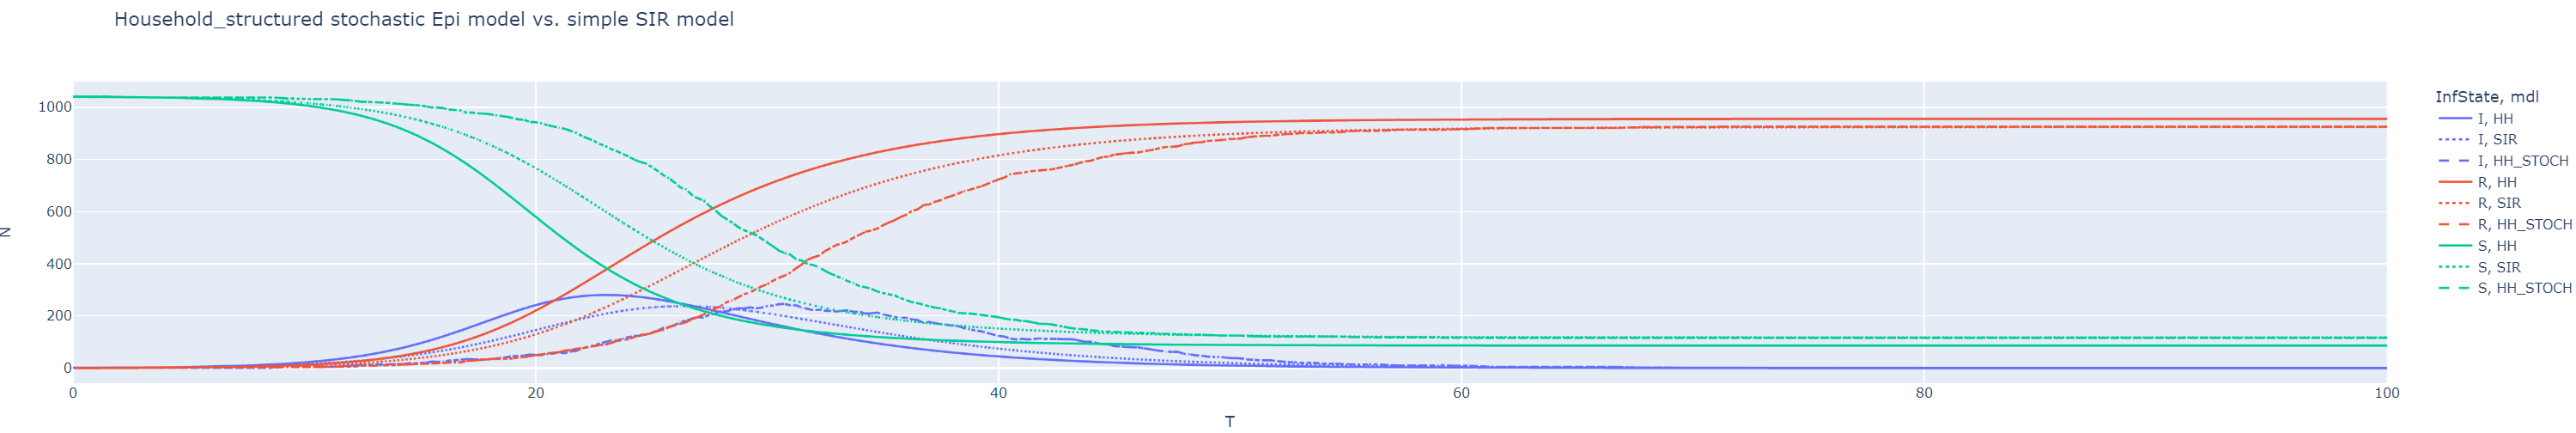